In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import itertools
import math
import cma
import scipy
from scipy import stats

## Import dataset

In [2]:
Data = []
with open("data.csv") as f:
    tmp = [line.split() for line in f]        # create a list of lists
    for i, x in enumerate(tmp):              #print the list items 
        Data.append(x[0].split(','))
# Data[3]
len(Data)

200006

## Assign value

In [3]:
m = int(Data[0][0])
A = int(Data[1][0])
k = int(Data[2][0])
thetab = np.array(Data[3]).astype(np.float).reshape(2,2)
n = int(Data[4][0])
Episodes = []
for i in range(n):
    Episodes.append(np.array(Data[i+5]).astype(np.float))
Episodes = np.array(Episodes)
FirstEp = np.array(Data[200005]).astype(np.float)
print("Number of state features: %d\nNumber of discrete actions: %d\nFourier basis order: %d\nParameters of the policy:%s\nNumber of episodes:%d"%(m,A,k,np.array2string(thetab),n))
print("10 example episodes:\n", Episodes[:10])
print("First Episode: ",FirstEp)

Number of state features: 1
Number of discrete actions: 2
Fourier basis order: 1
Parameters of the policy:[[ 0.01 -0.01]
 [ 1.    1.  ]]
Number of episodes:200000
10 example episodes:
 [array([ 0.419908 ,  1.       ,  0.992628 ,  0.366283 ,  0.       ,
       10.       ,  0.0622811,  1.       ,  2.98566  ,  0.327772 ,
        1.       ,  1.69524  ,  0.612293 ,  0.       ,  6.10134  ])
 array([ 0.452796,  1.      , -2.49912 ,  0.526937,  1.      ,  7.42631 ,
        0.335302,  1.      ,  7.42853 ])
 array([ 0.536244,  1.      , -3.91362 ,  0.522716,  1.      ,  1.51771 ,
        0.40803 ,  1.      , -1.25238 ])
 array([ 0.594378,  1.      ,  0.023878,  0.610604,  1.      , -1.20107 ,
        0.530918,  0.      ,  4.92925 ,  0.588444,  1.      , -3.52819 ,
        0.479734,  1.      , -2.66537 ])
 array([ 0.574179,  1.      , -0.366696,  0.407571,  1.      , -0.199698,
        0.459103,  1.      , -3.85923 ,  0.54211 ,  0.      , -2.21454 ,
        0.471514,  1.      , -0.276811])
 array

## Process

1. split Dataset $D$ into $D_c$ and $D_s$
2. Use $D_c$ to select $\theta c$ according to 
$$\theta_c\in \mathop {argmax}_{\theta} PDIS(D_c,\theta,\pi_b)$$
3. Next, run the safety test. That is, if 
$$PDIS(D_s,\theta,\pi_b)-\frac{\hat{\sigma}_s}{\sqrt{|D_s|}}t_{1-\delta,|D_s|-1}\geq c$$
holds, return $\theta c$, and otherwise return NSF.

In [4]:
# split dataset
D_c = Episodes[:120000]
D_s = Episodes[120000:]
D_c.shape, D_s.shape
# print(D_c[0])
# print(D_s[0])

((120000,), (80000,))

In [5]:
# calculate pi_b
pi_b = np.zeros((m,A))

c = [list(i) for i in itertools.product(range(k), repeat=4)] # k is dorder

In [6]:
# define FourierBasis

class FourierBasis:
    def __init__(self, inputDimension, iOrder, dOrder):
        self.inputDimension = inputDimension
        iTerms = iOrder*inputDimension;#Number of independent terms
        dTerms = int(math.pow(dOrder + 1, inputDimension))# Number of dependent terms
        oTerms = min(iOrder, dOrder)*inputDimension # Overlap of iTerms and dTerms
        self.nTerms = iTerms + dTerms - oTerms
#         print(iTerms,dTerms,oTerms,self.nTerms)
        counter = np.zeros(inputDimension)
        self.c = np.zeros((self.nTerms, inputDimension))
        termCount = 0;
        while termCount<dTerms:
            self.c[termCount] = counter
            self.incrementCounter(counter, dOrder)
            termCount+=1

        for i in range(inputDimension):# Add the independent terms
            j = dOrder+1

            while  j <= iOrder:
#                 print("================")
                self.c[termCount][i] = double(j)
                termCount+=1
                j+=1
#                 print(j)
#         print(self.c,self.c.shape)

    def getNumOutputs(self):
        return self.nTerms
    
    def incrementCounter(self,buff, maxDigit):
        for i in range(buff.shape[0]):
            buff[i]+=1
            if buff[i] <= maxDigit:
                break
            buff[i] = 0

    def basify(self, x):
        result = np.zeros(self.nTerms)
#         print("c[i] x")
        for i in range(self.nTerms):
            result[i] = np.cos(math.pi* np.dot(self.c[i], x))
#             print(c[i],x)
#             print(np.dot(self.c[i], x))
        return result

# fb = FourierBasis(4, 2, 3)
# s = np.array([0.32,0.23,1.3,-5.0])
# phi = fb.basify(s)
# print(phi)
fb = FourierBasis(m, 1, k)
s = np.array([0.419908])
phi = fb.basify(s)
print(phi)

[1.         0.24896982]


In [7]:
# define function to calculate pi_b
fb = FourierBasis(m, k, k)
def calculate_pi(s,a,fb,theta):
    phi = fb.basify(s) #2*1
    up = np.exp(phi.dot(theta[a]))
    down = np.sum(np.exp(phi.dot(theta.T)))
    return up/down
for i in range(len(Episodes[0])):
    if i%3==0:
        print(calculate_pi(np.array([Episodes[0][i]]),int(Episodes[0][i+1]),fb,thetab))

0.7758179628829157
0.19751227246411232
0.8787587888894525
0.8190914628552088
0.34501192170711364


(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=308362, Thu Dec 12 14:31:46 2019)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.095087259738059e+01 1.0e+00 4.34e-01  4e-01  4e-01 0:00.0
    2     16 2.082090090176014e+01 1.2e+00 3.65e-01  3e-01  3e-01 0:00.0
    3     24 1.071432019634534e+01 1.3e+00 3.40e-01  2e-01  3e-01 0:00.0
  100    800 1.142913219457120e-02 2.7e+01 8.15e-02  5e-03  3e-02 0:00.2
  200   1600 6.563298910565113e-15 5.8e+01 9.20e-06  1e-08  1e-07 0:00.5
  205   1640 4.951669326641235e-15 6.9e+01 7.31e-06  1e-08  1e-07 0:00.5
termination on tolfun=1e-11
final/bestever f-value = 4.951669e-15 2.004325e-15
incumbent solution: [1.0000000054097542, 1.0000000159827103, 1.0000000313360542, 1.0000000632055877]
std deviation: [1.2495376431299991e-08, 2.348979410972655e-08, 4.700735796937156e-08, 9.527346971980382e-08]


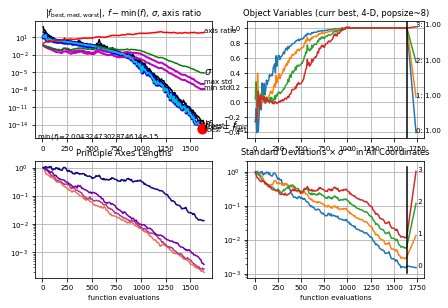

In [8]:
# create random policies
# this part can skip, it's testing cma es.
es = cma.CMAEvolutionStrategy(4 * [0], 0.5)
solutions = es.ask()
solutions
while not es.stop():
    solutions = es.ask()# ask for n policies
    es.tell(solutions,[cma.ff.rosen(x) for x in solutions])
    es.logger.add()  # write data to disc to be plotted
    es.disp()
es.result_pretty()
cma.plot()  # shortcut for es.logger.plot()


In [9]:
def calculate_PDIS_H(thetae,thetab,epi,fb):
    pie_pib = 1.0
    ret = 0.0
    for t in range(epi.shape[0]):
        if t%3==0:
            s = np.array([epi[t]])
            a = int(epi[t+1])
            r = epi[t+2]
            up = calculate_pi(s,a,fb,thetae)
            down = calculate_pi(s,a,fb,thetab)
            pie_pib = pie_pib*(up/down)
            ret+=pie_pib*r
    return ret
print(calculate_PDIS_H(np.array(es.ask(1)).reshape(2,2),thetab,Episodes[10],fb))

-0.24408172205100676


In [10]:
def calculate_PDIS_D(episodes,thetae,thetab,fb):
    ret = []
    for epi in episodes:
        ret.append(calculate_PDIS_H(thetae,thetab,epi,fb))
    return np.mean(np.array(ret)),np.std(np.array(ret), ddof=1)
print(calculate_PDIS_D(D_c,np.array(es.ask(1)).reshape(2,2),thetab,fb))

(4.0617399222088775, 19.699162658599345)


In [20]:
from scipy.stats import t
sigma = 0.1#2.0*(thetab.reshape(-1).dot(thetab.reshape(-1)) + 1.0)# sigma not sure
print("sigma: ",sigma)
es = cma.CMAEvolutionStrategy(np.zeros(4,), sigma)# start search from pi_b thetab.reshape(-1)
delta = 0.1
c = 0
min1 = 10000
D_s_size = 80000
flag = True
while not es.stop() and flag:
    solutions = es.ask(8)# ask for n policies
    tell = []
    for x in solutions:
        pred,sig = calculate_PDIS_D(D_c,np.array(x).reshape(2,2),thetab,fb)
        t_test = pred-2*sig/np.sqrt(D_s_size)*t.ppf(1-delta,D_s_size-1)
        if pred<min1:
            min1 = pred
        print("pred:",pred)
        print("t_test:",t_test)
#         print(c)
        if np.isnan(t_test):
            flag = False
        if t_test <c:
#             print("bad!")
            pred = -100000-pred
        pred = -pred
        tell.append(pred)
    es.tell(solutions,tell)
#     es.tell(solutions,[-calculate_PDIS_D(D_c[:100],np.array(x).reshape(2,2),thetab,fb)[0] for x in solutions])
    es.logger.add()  # write data to disc to be plotted
    es.disp()
es.result_pretty()
cma.plot()  # shortcut for es.logger.plot()
print("min:",min1)

sigma:  0.1
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=320471, Thu Dec 12 18:53:20 2019)
pred: 4.412320868283647
t_test: 4.2151932007978425
pred: 3.4192417075546953
t_test: 3.2786813410899525
pred: 3.7795104742658134
t_test: 3.6247283897471796
pred: 4.84613268502485
t_test: 4.593916728820315
pred: 4.857748632748035
t_test: 4.608910266889866
pred: 3.799039107789486
t_test: 3.6462631325462747
pred: 3.5508148149434167
t_test: 3.404620664810853
pred: 3.9535970588463223
t_test: 3.779009439197936
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -4.857748632748035e+00 1.0e+00 1.01e-01  1e-01  1e-01 5:27.2
pred: 4.280651364896219
t_test: 4.076113060083533
pred: 5.119163374777717
t_test: 4.826883087375781
pred: 5.320844770241839
t_test: 5.026536867386414
pred: 4.547930528614516
t_test: 4.323536212409553
pred: 5.080056863060466
t_test: 4.834435528263936
pred: 4.125636741421771
t_test: 3.94421352930066
pred: 4.5567655517830925
t_test: 4.33001749257

pred: 15.165056912300434
t_test: 11.917693587931812
   17    136 -1.516505691232945e+01 2.8e+00 5.08e+00  4e+00  8e+00 102:15.3
pred: 15.165056898616594
t_test: 11.917693579717058
pred: 15.165056912325634
t_test: 11.917693587942956
pred: 15.1650569123293
t_test: 11.91769358794357
pred: 15.165056912328915
t_test: 11.917693587943319
pred: 15.165056749744823
t_test: 11.917693561213385
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
   18    144 -1.516505691232948e+01 3.4e+00 7.24e+00  5e+00  1e+01 164:12.5
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165027133211954
t_test: 11.917671514808786
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056888558405
t_test: 11.917693590197747
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.1650569123

C:\Users\gx\Anaconda3\lib\site-packages\cma\utilities\utils.py:333: UserWarning: flat fitness (f=-15.165057, sigma=7.64e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=21)
  ')')


pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.16505691232948
t_test: 11.9176935879436
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
   22    176 -1.516505691232948e+01 3.5e+00 7.69e+00  5e+00  1e+01 173:51.8
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
   23    184 -1.516505691232948e+01 3.5e+00 7.98e+00  5e+00  1e+01 176:08.4


C:\Users\gx\Anaconda3\lib\site-packages\cma\utilities\utils.py:333: UserWarning: flat fitness (f=-15.165057, sigma=7.98e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=23)
  ')')


pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
   24    192 -1.516505691232948e+01 3.4e+00 7.81e+00  5e+00  1e+01 178:15.3


C:\Users\gx\Anaconda3\lib\site-packages\cma\utilities\utils.py:333: UserWarning: flat fitness (f=-15.165057, sigma=7.81e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=24)
  ')')


pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
   25    200 -1.516505691232948e+01 4.0e+00 6.95e+00  5e+00  1e+01 180:21.2


C:\Users\gx\Anaconda3\lib\site-packages\cma\utilities\utils.py:333: UserWarning: flat fitness (f=-15.165057, sigma=6.95e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=25)
  ')')


pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
   26    208 -1.516505691232948e+01 4.0e+00 7.01e+00  5e+00  1e+01 182:26.8


C:\Users\gx\Anaconda3\lib\site-packages\cma\utilities\utils.py:333: UserWarning: flat fitness (f=-15.165057, sigma=7.01e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=26)
  ')')


pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
pred: 15.165056912329481
t_test: 11.917693587943601
   27    216 -1.516505691232948e+01 4.9e+00 6.22e+00  4e+00  1e+01 184:30.6


C:\Users\gx\Anaconda3\lib\site-packages\cma\utilities\utils.py:333: UserWarning: flat fitness (f=-15.165057, sigma=6.22e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=27)
  ')')


pred: 15.165056912329481
t_test: 11.917693587943601


KeyboardInterrupt: 

In [23]:
print(es.ask(1))

[array([ 27.65017166,  -4.03457532, -24.25931462,   2.92022951])]


In [24]:
# t test
X, delta = calculate_PDIS_D(D_c,np.array([ 32.19519699,9.61624397,-13.52908398,3.04278752]).reshape(2,2),thetab,fb)
print(X)

15.165056912329481


In [24]:
safety = X-2*delta/np.sqrt(D_s_size)*scipy.stats.t.ppf(1-0.5,D_s_size-1)
print(safety)

12.337899658848881


In [285]:
print(scipy.stats.t.ppf(1-delta,D_s_size-1))

6.638010660180646e-17


In [26]:
# run safety test
solutions = es.ask(1000)
final_solutions = []
for s in solutions:
#     print(".", end="")
#     pred,_ = calculate_PDIS_D(D_c[:1000],np.array(s).reshape(2,2),thetab,fb)
    pred,sig = calculate_PDIS_D(D_s,np.array([ 32.19519699,9.61624397,-13.52908398,3.04278752]).reshape(2,2),thetab,fb)# s
    print(pred)
#     print(sig/np.sqrt(D_s_size)*scipy.stats.t.ppf(1-delta,D_s_size-1))
    safety = pred - sig/np.sqrt(D_s_size)*scipy.stats.t.ppf(1-delta,D_s_size-1)
    if safety>=4:
        print(".",end="")
        final_solutions.append(s)
    if(len(final_solutions)==100):
        break
print(len(final_solutions))
print(final_solutions)

13.898726611378088
13.898726611378088


KeyboardInterrupt: 

In [ ]:
import csv
for i in range(100):
    with open('./data/'+str(i+1) + '.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow([str(final_solutions[i][j]) for j in range(len(final_solutions[i]))])

## Use cartpole to test the algorithm

In [12]:
# evaluate cartpole
from rl687.environments.cartpole import Cartpole
from rl687.policies.tabular_softmax import TabularSoftmax

# def generatephi(state):
#     ret = []
#     for i in range(3):
#         for j in range(3):
#             for m in range(3):
#                 for n in range(3):
#                     ret.append((state[0]**i)*(state[1]**j)*(state[2]**m)*(state[3]**n))
#     print(len(ret))
#     return np.array(ret)


def evaluationFunction2(theta_p,numEpisodes):
    """
    evaluationFunction (function): evaluates the provided parameterized policy.
    input: theta_p (numpy.ndarray, a parameterized policy), numEpisodes
    output: the estimated return of the policy
    """

    # init the gridworld
    cartpole = Cartpole()
    returns = np.zeros(numEpisodes)

    theta = theta_p.reshape(2,-1) # divide to each function

    for epoch in range(numEpisodes):
        cartpole.reset()
        step = 0
        g = 0
        s = [0.,0.,0.,0.]
        while not cartpole.isEnd:
#             phi = generatephi(s)
            fb2 = FourierBasis(len(s), 1, 1)
            phi = fb2.basify(s)
#             print(phi.shape)
            Psa = np.dot(phi,theta.T)
            action = 0
            if Psa[0]<Psa[1]:
                action = 1
            s, r, e = cartpole.step(action)
            g += (cartpole.gamma ** step) * r
            step += 1
        returns[epoch] = g
    return returns.mean()

# test cma es for cartpole policy selection
es = cma.CMAEvolutionStrategy(32*[0], 1)# start search from pi_b
solutions = es.ask()
while not es.stop():
    solutions = es.ask()# ask for n policies
    es.tell(solutions,[-evaluationFunction2(x,10) for x in solutions])
    es.logger.add()  # write data to disc to be plotted
    es.disp()
es.result_pretty()
cma.plot()  # shortcut for es.logger.plot()


(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=132704, Tue Dec 10 22:31:29 2019)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -5.300000000000000e+01 1.0e+00 9.38e-01  9e-01  9e-01 0:00.4
    2     28 -4.700000000000000e+01 1.1e+00 8.96e-01  9e-01  9e-01 0:00.8
    3     42 -3.200000000000000e+01 1.1e+00 8.59e-01  8e-01  9e-01 0:01.1
    9    126 -9.400000000000000e+01 1.2e+00 8.46e-01  8e-01  9e-01 0:04.1


KeyboardInterrupt: 

In [15]:
# generate random episodes with behavior policy and use it to test cma es by the way
def GenerateCartpoleData(theta_p):
    cartpole = Cartpole()
    theta = theta_p.reshape(2,-1) # divide to each function
    cartpole.reset()
    step = 0
    g = 0
    s = [0.,0.,0.,0.]
    S = []
    A = []
    R = []
    S.append(s)
    while not cartpole.isEnd:
        fb2 = FourierBasis(len(s), 1, 1)
        phi = fb2.basify(s)
#         print(theta.shape)
        Psa = np.dot(phi,theta.T)
        action = 0
        if Psa[0]<Psa[1]:
            action = 1
        s, r, e = cartpole.step(action)
        A.append(int(action))
        S.append(s)
        R.append(r)
#         g += (cartpole.gamma ** step) * r
        step += 1
    return S[0:-1],A,R
es = cma.CMAEvolutionStrategy(32*[0], 1)# start search from pi_b
new_theta_b = np.array(es.ask(1))
print("pi_B: ",new_theta_b)
A,S,R = GenerateCartpoleData(new_theta_b)
print("A:",len(A))
print(A)
print("S:",len(S))
print(S)
print("R:",len(R))
print(R)
# Rett[i] = evaluationFunction2(new_theta_b ,100)
# print(Rett[i])

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=158600, Tue Dec 10 22:33:06 2019)
pi_B:  [[ 1.60099347  0.16817724 -1.06891218  0.36363451  0.75959176  0.76664455
  -0.13805116 -1.14655205  1.25949261  0.37331885  0.49091052  1.02867167
  -0.08210027  0.64607996  0.92785426  0.19242973  0.39021695  1.13769559
  -1.85683741  2.26609458  1.07452256  0.52061546 -0.16637416  0.735372
  -0.20085704 -0.3208897   0.16030497 -1.11630003 -0.94605498 -1.31859223
  -0.51873905 -1.18672404]]
A: 25
[[0.0, 0.0, 0.0, 0.0], array([ 0.        , -0.19512195,  0.        ,  0.29268293]), array([-0.00390244, -0.3902439 ,  0.00585366,  0.58536585]), array([-0.01170732, -0.58544736,  0.01756098,  0.87988698]), array([-0.02341626, -0.39056834,  0.03515872,  0.59277619]), array([-0.03122763, -0.58616436,  0.04701424,  0.89632344]), array([-0.04295092, -0.39171026,  0.06494071,  0.61878169]), array([-0.05078512, -0.58767631,  0.07731634,  0.9311903 ]), array([-0.06253865, -0.39367812,  0.09594015,  0.

In [19]:

def calculate_PDIS_H(theta_e,theta_b,S,A,R,fb):
    pie_pib = 1.0
    ret = 0.0
    for (s, a, r) in zip(S, A, R): 
#         print("r",r)
        up = calculate_pi(s,a,fb,theta_e.reshape(2,-1))
        down = calculate_pi(s,a,fb,theta_b.reshape(2,-1))
        pie_pib = pie_pib*(up/down)
        ret+=pie_pib*r
    return ret
# print(calculate_PDIS_H(np.array(es.ask(1)).reshape(2,2),thetab,Episodes[10],fb))

def calculate_PDIS_D(thetae,theta_b,fb):
    ret = []
    for i in range(1000):
        S,A,R = GenerateCartpoleData(theta_b)
#         print()
        ret.append(calculate_PDIS_H(thetae,theta_b,S,A,R,fb))
    return np.mean(np.array(ret)),np.std(np.array(ret), ddof=1)
# print(calculate_PDIS_D(D_c,np.array(es.ask(1)).reshape(2,2),thetab,fb))


sigma = 1.0#2.0*(new_theta_b.dot(new_theta_b.T) + 1.0).reshape(-1)# sigma not sure
print("sigma: ",sigma)
print("new theta b: ",new_theta_b)
es = cma.CMAEvolutionStrategy(new_theta_b, sigma)# start search from pi_b
delta = 0.1
c = 5
min1 = 10000
D_s_size = 1000
fb2 = FourierBasis(4, 1, 1)
while not es.stop():
    solutions = es.ask()# ask for n policies
    tell = []
    for x in solutions:
        pred,sig = calculate_PDIS_D(np.array(x),new_theta_b,fb2)
        if pred<min1:
            min1 = pred
        t_test = pred-2*sig/np.sqrt(D_s_size)*scipy.stats.t.ppf(1-delta,D_s_size-1)
#         print(c)
        if np.isnan(t_test):
            print("???")
        if t_test <c or np.isnan(t_test):
            print("bad!")
            pred = -100000-pred
        pred = -pred
        tell.append(pred)
    es.tell(solutions,tell)
#     es.tell(solutions,[-calculate_PDIS_D(D_c[:100],np.array(x).reshape(2,2),thetab,fb)[0] for x in solutions])
    es.logger.add()  # write data to disc to be plotted
    es.disp()
es.result_pretty()
cma.plot()  # shortcut for es.logger.plot()
print("min:",min1)

sigma:  1.0
new theta b:  [[ 1.60099347  0.16817724 -1.06891218  0.36363451  0.75959176  0.76664455
  -0.13805116 -1.14655205  1.25949261  0.37331885  0.49091052  1.02867167
  -0.08210027  0.64607996  0.92785426  0.19242973  0.39021695  1.13769559
  -1.85683741  2.26609458  1.07452256  0.52061546 -0.16637416  0.735372
  -0.20085704 -0.3208897   0.16030497 -1.11630003 -0.94605498 -1.31859223
  -0.51873905 -1.18672404]]
(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 32 (seed=191706, Tue Dec 10 22:40:02 2019)


C:\Users\gx\Anaconda3\lib\site-packages\cma\utilities\utils.py:333: UserWarning: input x0 should be a list or 1-D array, trying to flatten (1, 32)-array ()
  ')')


bad!
bad!
bad!
bad!
bad!
bad!
bad!
bad!
bad!
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -4.406408456061214e+01 1.0e+00 9.35e-01  9e-01  9e-01 1:04.3
bad!
bad!
bad!
bad!
bad!
bad!
bad!
bad!
bad!
    2     28 -7.978259426851649e+01 1.1e+00 9.02e-01  9e-01  9e-01 2:09.2
bad!
bad!
bad!
bad!
bad!
bad!
    3     42 -9.248315719269857e+01 1.1e+00 8.88e-01  9e-01  9e-01 3:13.2
bad!
bad!
bad!
bad!
    4     56 -1.628667217022519e+02 1.1e+00 8.74e-01  9e-01  9e-01 4:16.6
bad!
bad!
    5     70 -1.519758819041118e+02 1.1e+00 8.62e-01  8e-01  9e-01 5:19.8
bad!
    6     84 -1.648348946369301e+02 1.1e+00 8.76e-01  9e-01  9e-01 6:22.8
    7     98 -1.431892778035963e+02 1.2e+00 8.84e-01  9e-01  9e-01 7:46.3
bad!
    8    112 -1.815334607047753e+02 1.2e+00 8.88e-01  9e-01  9e-01 8:57.0
    9    126 -2.963845018534108e+02 1.2e+00 9.06e-01  9e-01  9e-01 10:01.2
   10    140 -2.692426182769794e+02 1.3e+00 9.39e-01  9e-01  1e+00 11:04.7
   11    154 -2.5259924202

KeyboardInterrupt: 

In [20]:
# run safety test
solutions = es.ask(1000)
final_solutions = []
for s in solutions:
    pred,sig = calculate_PDIS_D(np.array(s),new_theta_b,fb2)
    print(pred)
    safety = pred - sig/np.sqrt(D_s_size)*scipy.stats.t.ppf(1-delta,D_s_size-1)
    if safety>=c:
        final_solutions.append(s)
    if(len(final_solutions)>100):
        break
print(len(final_solutions))
print(final_solutions)

final_solutions = np.array(final_solutions)
# Rett = np.zeros(100)
# solutions = np.array(es.ask(100))

for i in range(100):
    Rett[i] = evaluationFunction2(final_solutions[i] ,100)
    print(Rett[i])
print((Rett>evaluationFunction2(new_theta_b ,100)).sum())

550.5042959134435
550.5038626705972
550.5026637985467
550.504180049419
550.5013985468221
550.5035232495131


KeyboardInterrupt: 

In [22]:
Rett = np.zeros(100)
for i in range(100):
    Rett[i] = evaluationFunction2(solutions[i] ,100)
    print(Rett[i])
print((Rett>evaluationFunction2(new_theta_b ,100)).sum())

25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0


KeyboardInterrupt: 